Topic: Variation in Listing Price and Rating by Geography

Dataset: http://data.insideairbnb.com/canada/bc/vancouver/2023-12-13/data/listings.csv.gz , and same files for previous 3 quarters of data.

Approach/Question: Using this data set, we will explore how AirBnB listing price and rating varied by geography in Vancouver, BC in 2023. Specifically, we believe that neighborhood is a key driver of both listing price and rating even after accounting for the effect of listing type (single room vs entire dwelling) and time of year. To answer this question, we will group the dataset by neighborhood, listing type, and calendar quarter and calculate the mean (std) and median (IQR) listing price and rating. We will examine distributions of listing price and rating to assess for outliers and determine which measure of centre is more appropriate. Finally, we will create bar charts of the appropriate measure of centre by neighborhood for visual comparison, and a map showing price and listing in each neighborhood.

Team: Ben S., Joey S., Johanna B, Jonas S., Jordan V.

In [1]:
"""The point of this code block is to import libraries and load data.

The data files are four CSV files located in the Data Source subfolder
of the root drive.
"""
# Import libraries. Commented out the pip install commands since they
# only need to be run once.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %pip install seaborn
# %pip install scipy
# %pip install folium
# %pip install geopy
import folium
import seaborn as sns
from datetime import datetime


# Read CSV files into DataFrames.
abnb_q4 = pd.read_csv('listings_Dec2023.csv')
abnb_q3 = pd.read_csv('listings_Sep2023.csv')
abnb_q2 = pd.read_csv('listings_Jun2023.csv')
abnb_q1 = pd.read_csv('listings_Mar2023.csv')

# Stack the four DataFrames into one and print out columns.
abnb_orig = pd.concat(
    [abnb_q4,
     abnb_q3,
     abnb_q2,
     abnb_q1
     ],
    ignore_index=True
)


In [2]:
#Adding all the columns to read
abnb_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25716 entries, 0 to 25715
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            25716 non-null  int64  
 1   listing_url                                   25716 non-null  object 
 2   scrape_id                                     25716 non-null  int64  
 3   last_scraped                                  25716 non-null  object 
 4   source                                        25716 non-null  object 
 5   name                                          25716 non-null  object 
 6   description                                   18961 non-null  object 
 7   neighborhood_overview                         17010 non-null  object 
 8   picture_url                                   25716 non-null  object 
 9   host_id                                       25716 non-null 

In [3]:
"""Data cleaning code."""

# Keep just the columns we want.
#ADDING amenities
abnb = abnb_orig[
    ['last_scraped',
     'id',
     'host_id',
     'host_since',
     'host_is_superhost',
     'host_total_listings_count',
     'neighbourhood_cleansed',
     'latitude',
     'longitude',
     'property_type',
     'room_type',
     'accommodates',
     'beds',
     'price',
     'number_of_reviews',
     'number_of_reviews_ltm',
     'review_scores_rating',
     'reviews_per_month','amenities'
     ]
]

# Rename the neighbourhood column to make it more concise.
abnb = abnb.rename(columns={"neighbourhood_cleansed": "neighbourhood"})

# Convert prices from string to float.
# Replace $ symbol with nothing.
abnb.loc[:, 'price'] = abnb.loc[:, "price"].str.replace("$", "")
# Replace commas with nothing.
abnb.loc[:, 'price'] = abnb.loc[:, "price"].str.replace(",", "")
# Change column type from string to numeric.
abnb["price"] = pd.to_numeric(abnb["price"])

# Get rid of rows that do not have price or bed data.
abnb = abnb[-pd.isna(abnb["price"])]
abnb = abnb[-pd.isna(abnb["beds"])]

# The original DataFrame had a problem with outliers.
# Remove rows with a price above $1000.00.
abnb = abnb[abnb['price'] <= 1000]

# Make a month column out of the last_scraped column.
abnb['last_scraped'] = pd.to_datetime(abnb['last_scraped'])
abnb['month'] = abnb['last_scraped'].dt.month

# Define the q4 DataFrame as anything in the 12th month.
abnb_q4 = abnb[abnb['month'] == 12]

# Show some information.
print(abnb.info())
print(abnb_q4.info())
print(abnb.head(5))
print(abnb['month'].value_counts())



<class 'pandas.core.frame.DataFrame'>
Index: 24469 entries, 0 to 25715
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   last_scraped               24469 non-null  datetime64[ns]
 1   id                         24469 non-null  int64         
 2   host_id                    24469 non-null  int64         
 3   host_since                 24469 non-null  object        
 4   host_is_superhost          23107 non-null  object        
 5   host_total_listings_count  24469 non-null  int64         
 6   neighbourhood              24469 non-null  object        
 7   latitude                   24469 non-null  float64       
 8   longitude                  24469 non-null  float64       
 9   property_type              24469 non-null  object        
 10  room_type                  24469 non-null  object        
 11  accommodates               24469 non-null  int64         
 12  beds     

Index(['Downtown', 'West End', 'Kitsilano', 'Mount Pleasant',
       'Kensington-Cedar Cottage', 'Downtown Eastside', 'Riley Park',
       'Grandview-Woodland', 'Hastings-Sunrise', 'Renfrew-Collingwood',
       'Dunbar Southlands', 'Marpole', 'Fairview', 'Sunset',
       'Victoria-Fraserview'],
      dtype='object', name='neighbourhood')


<Axes: ylabel='Frequency'>

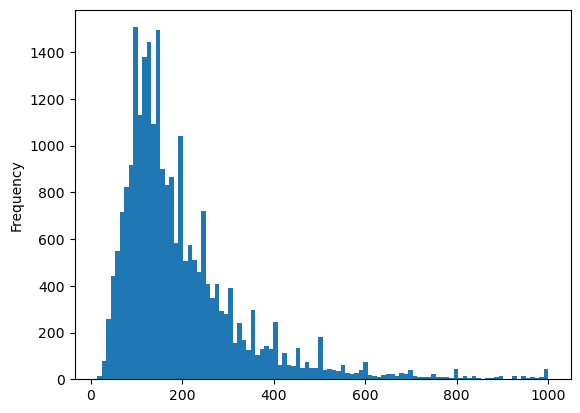

In [4]:
"""Histogram visualization of price in the 15 neighbourhoods
with the most listings.
"""

# Show the top 15 neighbourhoods with the most listings.
top_area = (
    abnb['neighbourhood']
    .value_counts()
    .sort_values(ascending=False)
    .head(15)
    .index
)
print(top_area)

# Plot the price of the top 15 neighbourhoods by number of listings.
abnb['price'].plot.hist(bins=100)

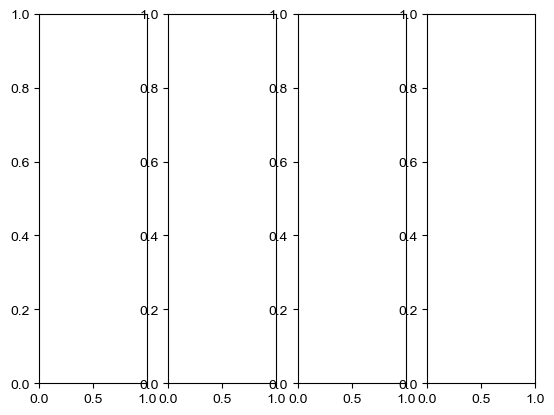

In [9]:
# Set subplot options.
fig, axes = plt.subplots(1, 4)
sns.set_style('whitegrid')
sns.set_palette('Greys_r')

In [10]:
# Create pivot table for second axis plot.
stat_by_neigh = pd.pivot_table(abnb_q4,
                               values=['price',
                                       'review_scores_rating',
                                       'id',
                                       'number_of_reviews_ltm',
                                       'latitude',
                                       'longitude'
                                       ],
                               index=['neighbourhood'],
                               aggfunc={'price': 'median',
                                        'review_scores_rating': 'median',
                                        'id': 'count',
                                        'number_of_reviews_ltm': 'sum',
                                        'latitude': 'median',
                                        'longitude': 'median'
                                        }
                               )

# Sort pivot table by descending review scores.
stat_by_neigh = (
    stat_by_neigh.sort_values(
        by='review_scores_rating',
        ascending=False)
    .reset_index()
)


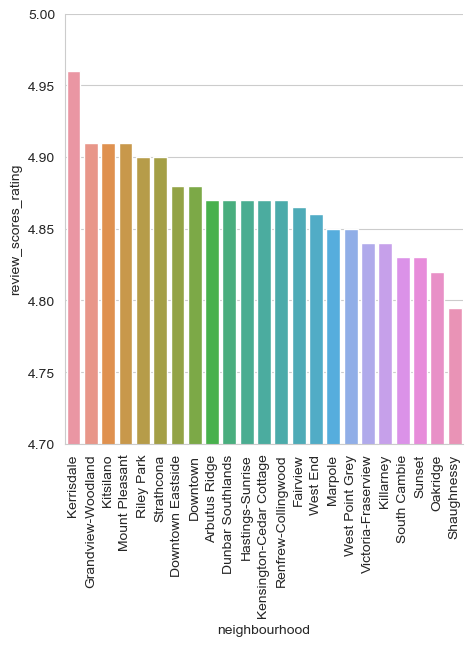

In [11]:
# Second subplot shows review scores by neighborhood.
axes[1] = sns.catplot(
    x='neighbourhood',
    y='review_scores_rating',
    kind='bar',
    data=stat_by_neigh
)
axes[1].set_xticklabels(rotation=90)
axes[1].set(ylim=(4.7, 5))



,neighbourhood,id,latitude,longitude,number_of_reviews_ltm,price,review_scores_rating
0,Kerrisdale,71,49.229198,-123.151440,953,109.0,4.960
1,Grandview-Woodland,208,49.272400,-123.065388,4015,130.0,4.910
2,Kitsilano,414,49.266810,-123.160800,5714,151.0,4.910
3,Mount Pleasant,373,49.263993,-123.101110,5215,130.0,4.910
4,Riley Park,262,49.248715,-123.101400,4355,130.0,4.900
5,Strathcona,28,49.269655,-123.099195,865,132.5,4.900
6,Downtown Eastside,328,49.281269,-123.102435,6706,150.0,4.880
7,Downtown,1529,49.278660,-123.121480,26738,163.0,4.880
8,Arbutus Ridge,101,49.245673,-123.162447,1484,125.0,4.870
9,Dunbar Southlands,174,49.243109,-123.183401,2156,123.5,4.870


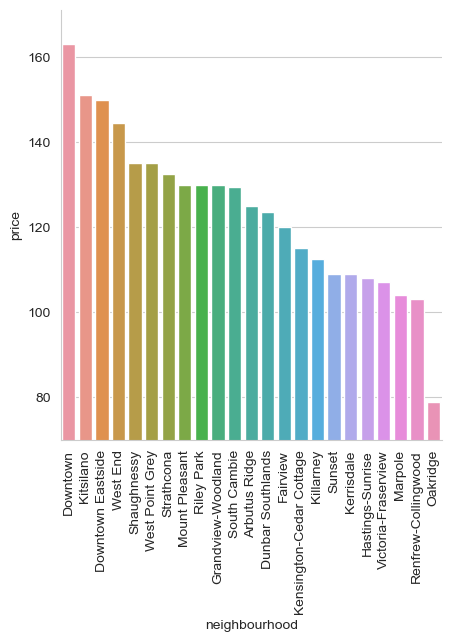

In [12]:
# Third subplot is a bar chart of most-expensive to least-expensive
# median prices by neighbourhood.
axes[2] = sns.catplot(
    x='neighbourhood',
    y='price',
    kind='bar',
    data=stat_by_neigh.sort_values(by='price', ascending=False)
)
axes[2].set_xticklabels(rotation=90)
axes[2].set(ylim=(70, None))

# Show the pivot table.
stat_by_neigh



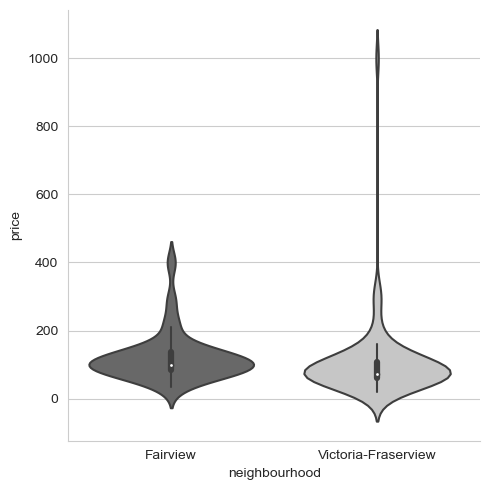

In [13]:
# Fourth subplot is a box plot of price in the Fairview and Victoria-
# Fraserview neighborhoods.
axes[3] = sns.catplot(
    x='neighbourhood',
    y='price',
    kind='violin',
    palette='Greys_r',
    data=(
        abnb[
            abnb['room_type'].isin(['Private room'])
            & abnb['neighbourhood'].isin(['Fairview', 'Victoria-Fraserview'])
        ]
    )
)

In [14]:
"""This code block creates a map showing median price and rating among
Vancouver neighbourhoods.
"""

# Create map object.
map = folium.Map(location=[49.24445179910618, -123.11257056533111],
                 zoom_start=12,
                 tiles="cartodb positron"
                 )

# Add popup icons to map.
for index, row in stat_by_neigh.iterrows():
    folium.Marker(
        [row['latitude'],
         row['longitude']
         ],
        popup=(
                row['neighbourhood'] + "\n"
                + "Rating: " + str(row['review_scores_rating'])
                + "\n" + "Price: $" + str(row['price'])
        )
    ).add_to(map)

# Show map.
map


In [15]:
##AMMENTITIES ANALYSIS

abnb['amenities_list'] = abnb['amenities'].str.strip('{}').str.replace('"', '').str.split(',')



In [16]:
# Create a set to hold unique amenities. Sets in Python automatically ignore duplicates, 
# making them an efficient way to collect a unique list of amenities from all listings.
unique_amenities = set()

# Loop through each listing's amenities in amenities_list and updating unique_amenities. 
#If these amenities are already in the set, nothing changes, ensuring each amenity is only listed once.

for amenities in abnb['amenities_list']:
    unique_amenities.update(amenities)

# Convert the set of unique amenities to a sorted list. 
#This makes the amenities easier to read and analyze by putting them in alphabetical order.

sorted_amenities = sorted(list(unique_amenities))

#Creating a numbered list of all unique ammenties using enumerate
#This loop goes through each amenity in 'sorted_amenities', 
#assigning it an index starting from 1, and prints it

for i, amenity in enumerate(sorted_amenities, 1):
    print(f"{i}. {amenity}")

1.   Fisher & Paykel Gas stainless steel oven
2.   Fisher & Paykel stainless steel stove
3.   Fulgor Milano stainless steel gas stove
4.   Head and shoulders Volumizing 2-in-one and the Envy Volumed Shampoo in use now  shampoo
5.   just ask! conditioner
6.  100% Eco Friendly Kirkland body soap
7.  100% Eco Friendly Kirkland conditioner
8.  100% Eco Friendly Kirkland shampoo
9.  100% Organic ECO Friendly Kirkland body soap
10.  100% Organic ECO Friendly Kirkland conditioner
11.  100% Organic ECO Friendly Kirkland shampoo
12.  100% Organic ECO by Public Goods body soap
13.  100% Organic ECO by Public Goods conditioner
14.  100% Organic ECO by Public Goods shampoo
15.  100% Organic ECO-Friendly Kirkland body soap
16.  100% Organic ECO-Friendly Kirkland body soap]
17.  100% Organic ECO-Friendly Kirkland conditioner
18.  100% Organic ECO-Friendly Kirkland shampoo
19.  100% Organic Kirkland body soap
20.  100% Organic Kirkland conditioner
21.  100% Organic Kirkland shampoo
22.  100% organic 

In [17]:
# Initialize a dictionary to hold the count of each amenity. 
#This will loop unique amenties and set the values of these keys to 0

amenity_counts = {amenity: 0 for amenity in unique_amenities}

# Count the occurrences of each amenity
# For each listing, it loops through its amenities and increments the count for each amenity in 'amenity_counts'.
for amenities in abnb['amenities_list']:
    for amenity in amenities:
        amenity_counts[amenity] += 1

# Convert to a DataFrame for easier analysis
amenity_counts_df = pd.DataFrame(list(amenity_counts.items()), columns=['Amenity', 'Count'])

# Sort the DataFrame by count to see the most common amenities
amenity_counts_df = amenity_counts_df.sort_values(by='Count', ascending=False)
amenity_counts_df

,Amenity,Count
2689,Smoke alarm,17926
1370,Kitchen,17035
2849,Essentials,16676
1381,Wifi,16187
2090,Dishes and silverware,15204
...,...,...
2831,Usually Dove or Nivea conditioner],1
245,Fast wifi \u2013 573 Mbps],1
1328,\u591a\u82ac conditioner,1
2835,Fast wifi \u2013 195 Mbps],1


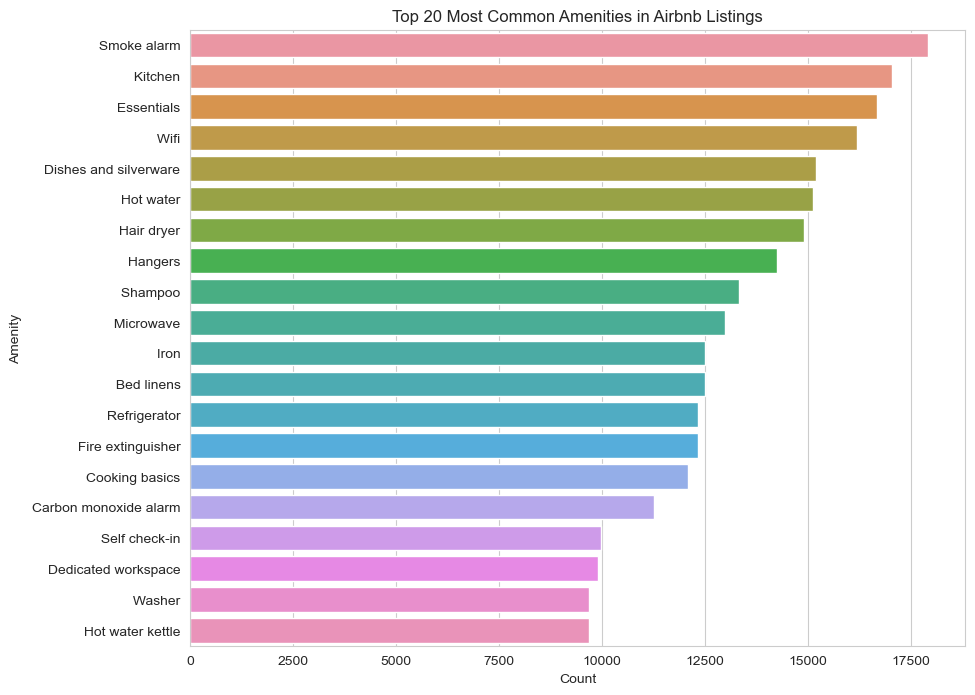

In [18]:
# Plot the top 20 most common amenities
plt.figure(figsize=(10, 8))
sns.barplot(data=amenity_counts_df.head(20), y='Amenity', x='Count')
plt.title('Top 20 Most Common Amenities in Airbnb Listings')
plt.xlabel('Count')
plt.ylabel('Amenity')
plt.show()

In [ ]:
parks_df = pd.read_csv('parks.csv',sep=';')

parks_df[['Latitude', 'Longitude']] = parks_df['GoogleMapDest'].str.split(',', expand=True)

parks_df

In [ ]:
print("Air BNB Neighbourhoods: ", abnb['neighbourhood'].unique(),'\n')
print("Parks Neighbourhoods: ", parks_df['NeighbourhoodName'].unique(),'\n')

In [ ]:
neighbourhood_mapping = {
    'Arbutus-Ridge': 'Arbutus Ridge',
    'Downtown': 'Downtown',
    'Dunbar-Southlands': 'Dunbar Southlands',
    'Fairview': 'Fairview',
    'Grandview-Woodland': 'Grandview-Woodland',
    'Hastings-Sunrise': 'Hastings-Sunrise',
    'Kensington-Cedar Cottage': 'Kensington-Cedar Cottage',
    'Kerrisdale': 'Kerrisdale',
    'Killarney': 'Killarney',
    'Kitsilano': 'Kitsilano',
    'Marpole': 'Marpole',
    'Mount Pleasant': 'Mount Pleasant',
    'Renfrew-Collingwood': 'Renfrew-Collingwood',
    'Riley Park': 'Riley Park',
    'Shaughnessy': 'Shaughnessy',
    'Strathcona': 'Strathcona',
    'Sunset': 'Sunset',
    'Victoria-Fraserview': 'Victoria-Fraserview',
    'West End': 'West End',
    'West Point Grey': 'West Point Grey',
    'South Cambie': 'South Cambie',
    'Oakridge': 'Oakridge',
}

parks_df['NeighbourhoodName'] = parks_df['NeighbourhoodName'].replace(neighbourhood_mapping)
parks_df['NeighbourhoodName']

In [ ]:
#Calculating the distance to the nearest park using great_circle from geopy

from geopy.distance import great_circle

# Define the function to find the nearest park's distance
def find_nearest_park_distance(airbnb_location, parks_df):
    min_distance = float('inf')  # Initialize with a very large number

    # Iterate over each park in the DataFrame
    for _, park in parks_df.iterrows():
        park_location = (park['Latitude'], park['Longitude'])
        distance = great_circle(airbnb_location, park_location).meters  # Calculate distance in meters

        # Update min_distance if the current park is closer
        if distance < min_distance:
            min_distance = distance

    return min_distance  # Return the minimum distance

# Apply the function to each Airbnb listing to calculate the closest park distance
abnb['distance_to_closest_park'] = abnb.apply(
    lambda x: find_nearest_park_distance((x['latitude'], x['longitude']), parks_df),
    axis=1
)

In [ ]:
#Nearest Park Name

def find_nearest_park(airbnb_location, parks_df):
    nearest_park_name = None
    min_distance = float('inf')

    for _, park in parks_df.iterrows():
        park_location = (park['Latitude'], park['Longitude'])
        distance = great_circle(airbnb_location, park_location).meters

        if distance < min_distance and distance <= 500:
            min_distance = distance
            nearest_park_name = park['Name']

    return nearest_park_name

# Apply the function to each Airbnb listing
abnb['NearestParkName'] = abnb.apply(
    lambda x: find_nearest_park((x['latitude'], x['longitude']), parks_df),
    axis=1
)

In [39]:
abnb = abnb.round({'distance_to_closest_park': 1})
abnb

,last_scraped,id,host_id,host_since,host_is_superhost,host_total_listings_count,neighbourhood,latitude,longitude,property_type,...,price,number_of_reviews,number_of_reviews_ltm,review_scores_rating,reviews_per_month,amenities,month,NearestParkName,amenities_list,distance_to_closest_park
0,2023-12-14,13188,51466,2009-11-04,f,3,Riley Park,49.247730,-123.105090,Entire rental unit,...,150.0,283,30,4.84,1.68,[],12,Hillcrest Park,[[]],411.0
1,2023-12-14,13221,51634,2009-11-05,f,4,Riley Park,49.254890,-123.097080,Entire rental unit,...,120.0,15,0,4.73,0.15,[],12,Tea Swamp Park,[[]],268.0
2,2023-12-14,13358,52116,2009-11-07,f,1,Downtown,49.281174,-123.125931,Entire condo,...,165.0,493,55,4.68,3.00,[],12,Nelson Park,[[]],323.0
3,2023-12-13,13490,52467,2009-11-08,t,4,Kensington-Cedar Cottage,49.256220,-123.066070,Entire rental unit,...,150.0,101,5,4.93,0.66,[],12,John Hendry (Trout Lake) Park,[[]],282.0
4,2023-12-13,14267,56030,2009-11-20,f,1,Kensington-Cedar Cottage,49.249220,-123.081390,Entire home,...,150.0,33,0,4.76,0.21,[],12,Glen Park,[[]],111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25711,2023-03-14,845284101352923786,504936838,2023-03-11,f,1,Riley Park,49.237248,-123.104728,Entire guest suite,...,104.0,0,0,NaN,NaN,"[""Heating"", ""Free dryer \u2013 In unit"", ""Toas...",3,None,"[[Heating, Free dryer \u2013 In unit, Toaste...",528.0
25712,2023-03-14,845854561820158781,49461922,2015-11-20,f,3,Mount Pleasant,49.269547,-123.110062,Entire rental unit,...,120.0,0,0,NaN,NaN,"[""Stainless steel single oven"", ""Freezer"", ""Tr...",3,Hinge Park,"[[Stainless steel single oven, Freezer, Tras...",151.0
25713,2023-03-14,845891831251005257,97054642,2016-09-28,f,2,Victoria-Fraserview,49.216332,-123.055613,Entire home,...,339.0,0,0,NaN,NaN,"[""Freezer"", ""Security cameras on property"", ""F...",3,Bobolink Park,"[[Freezer, Security cameras on property, Fre...",202.0
25714,2023-03-14,845936827653470100,3664868,2012-09-24,f,1,Kitsilano,49.259028,-123.156587,Private room in home,...,105.0,0,0,NaN,NaN,"[""Freezer"", ""Free dryer \u2013 In unit"", ""Toas...",3,Rosemary Brown Park,"[[Freezer, Free dryer \u2013 In unit, Toaste...",316.0


In [40]:
stat_by_neigh = pd.pivot_table(abnb,
                               values=['price',
                                       'review_scores_rating',
                                       'id',
                                       'number_of_reviews_ltm',
                                       'latitude',
                                       'longitude','distance_to_closest_park'
                                       ],
                               index=['neighbourhood'],
                               aggfunc={'price': 'median',
                                        'review_scores_rating': 'median',
                                        'id': 'count',
                                        'number_of_reviews_ltm': 'sum',
                                        'latitude': 'median',
                                        'longitude': 'median', 'distance_to_closest_park': 'mean'
                                        }
                               )

# Sort pivot table by descending review scores.
stat_by_neigh = (
    stat_by_neigh.sort_values(
        by='review_scores_rating',
        ascending=False)
    .reset_index()
)
stat_by_neigh

,neighbourhood,distance_to_closest_park,id,latitude,longitude,number_of_reviews_ltm,price,review_scores_rating
0,Kitsilano,322.459519,1828,49.266900,-123.161059,21885,180.0,4.91
1,Mount Pleasant,316.029814,1610,49.263174,-123.100809,19258,150.0,4.91
2,Grandview-Woodland,225.798000,1000,49.272607,-123.065406,15037,150.0,4.91
3,Strathcona,377.550000,140,49.269670,-123.098900,3188,179.0,4.90
4,Riley Park,378.805817,1169,49.248240,-123.101450,17654,149.0,4.90
5,Hastings-Sunrise,387.868718,975,49.278040,-123.042930,16149,120.0,4.89
6,Kensington-Cedar Cottage,327.539865,1480,49.248760,-123.074640,19958,130.0,4.88
7,Arbutus Ridge,318.784461,399,49.246340,-123.163950,5655,150.0,4.87
8,Downtown,227.780213,6479,49.278650,-123.121720,105935,199.0,4.87
9,West Point Grey,483.531707,410,49.262738,-123.203940,4665,168.0,4.87


In [41]:
stat_by_neigh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   neighbourhood             23 non-null     object 
 1   distance_to_closest_park  23 non-null     float64
 2   id                        23 non-null     int64  
 3   latitude                  23 non-null     float64
 4   longitude                 23 non-null     float64
 5   number_of_reviews_ltm     23 non-null     int64  
 6   price                     23 non-null     float64
 7   review_scores_rating      23 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.6+ KB


In [43]:
"""This code block creates a map showing median price and rating among
Vancouver neighbourhoods.
"""

# Create map object.
map = folium.Map(location=[49.24445179910618, -123.11257056533111],
                 zoom_start=12,
                 tiles="cartodb positron"
                 )

# Add popup icons to map.
for index, row in stat_by_neigh.iterrows():
    folium.Marker(
        [row['latitude'],
         row['longitude']
         ],
        popup=(
                row['neighbourhood'] + "\n"
                + "Rating: " + str(row['review_scores_rating'])
                + "\n" + "Price: $" + str(row['price']) + '\n' +"Park Distance :" + str(row['distance_to_closest_park'])
        )
    ).add_to(map)

# Show map.
map